In [385]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from typing import Union

from matplotlib import ticker
import numpy as np
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
import scipy.stats as sps
import src.geofunctions as gf

In [386]:
data, Data, population = gf.prepare_datasets(
    '../dat/tele_and_gov_data.csv',
    '../dat/surveillance_data.xlsx',
    '../dat/12411-0010-DLAND_population.csv'
)

geo_df = gf.load_gdp_data('../dat/ne_10m_admin_1_states_provinces/DE_shapes.csv')

geo_data = geo_df.merge(data, on = 'state')
geo_data['cases_6'] = geo_data.cases_6.apply(lambda x: 1 if x == 0 else x)
geo_data['laws_per_order'] = geo_data.cases_6 / geo_data.cases_4

In [387]:
sps.pearsonr(geo_data.query('year==2021').laws_per_order, geo_data.query('year==2021').case_4_proba)

PearsonRResult(statistic=0.47186193273556654, pvalue=0.06499148784897617)

In [388]:
data.query('year==2021')[['AfD', 'CDU', 'Grüne', 'Linke', 'case_4_proba']].corr()['case_4_proba']

AfD            -0.328368
CDU            -0.247763
Grüne           0.581077
Linke          -0.158786
case_4_proba    1.000000
Name: case_4_proba, dtype: float64

In [389]:
def Wald_test_Bern(n1: int, p1: float, n2: int, p2: float, how: str = 'two-sided'):
    """
    Perform Wald's test for Bernoulli distributed data.

    arguments:
    n1, n2 -- number of observations in group 1 & 2 respectively
    p1, p2 -- observed probabilities
    how -- desired alternative
    """
    assert how in ('two-sided', 'greater', 'less'), 'how is not defined'
    if n1 * n2 * (p1 + p2) == 0 :
        return None
    D = p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2 
    W = (p2 - p1) / D**(1/2)
    if how == 'two-sided':
        p = 2 * sps.norm.sf(abs(W))
    elif how == 'greater':
        p = sps.norm.sf(W)
    elif how == 'less':
        p = sps.norm.cdf(W)
    
    return round(W, 2), round(p, 5)
    

def stats_party(data, party):
    party_idx = data.parties.apply(lambda x: party in x)
    h1, n1 = data[~party_idx].sum()[['cases_4', 'population']]
    h2, n2 = data[party_idx].sum()[['cases_4', 'population']]
    p1, p2 = round(h1/n1, 6), round(h2/n2, 6)
    return n1, p1, n2, p2 

parties = ['Linke', 'SPD', 'CDU', 'Grüne', 'FW', 'FDP']

d = {k: [] for k in ('party', 'p_absent', 'n_absent', 'p_present', 'n_present', 'W', 'p_value')}

for party in parties:
    n1, p1, n2, p2 = stats_party(data.query('year==2021'), party)
    W, p = Wald_test_Bern(n1, p1, n2, p2)
    for k, v in zip(d.keys(), (party, p1, n1, p2, n2, W, p)):
        d[k].append(v)

pd.DataFrame(d)

,party,p_absent,n_absent,p_present,n_present,W,p_value
0,Linke,0.000194,75163166,0.000242,8073958,8.41,0.00000
1,SPD,0.000202,48521239,0.000193,34715885,-2.89,0.00389
2,CDU,0.000225,14034378,0.000193,69202746,-7.38,0.00000
3,Grüne,0.000162,41722119,0.000235,41515005,23.63,0.00000
4,FW,0.000181,70060135,0.000294,13176989,22.65,0.00000
5,FDP,0.000246,61206048,0.000067,22031076,-67.37,0.00000


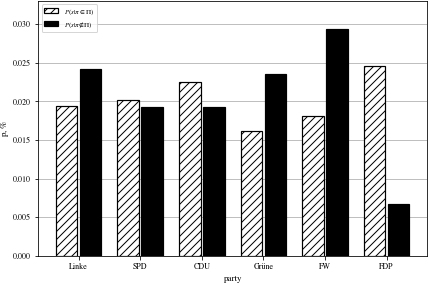

In [396]:
from tueplots import bundles
%matplotlib inline

fig, ax = plt.subplots(layout='constrained')

width = 0.35
x = np.arange(len(parties))
offset = 0.02

party_p = pd.DataFrame(d)

# plt.rcParams['hatch.linewidth'] = 0.5
style = {'edgecolor':'black', 'linewidth':1.2}
rect1 = ax.bar(x-width/2-offset, party_p.p_absent*100, width, label = '$P(s|\pi \in \Pi)$', color='white', hatch= '///', **style)
rect3 = ax.bar(x+width/2+offset, party_p.p_present*100, width, label = '$P(s|\pi \\notin \Pi)$', color='black', **style)

ax.set_xlabel('party')
ax.set_ylabel('p, %')
# ax.set_title('Probability of survilliance based on the\n presence of the party in government (2021)')
ax.set_xticks(x, party_p.party)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.legend(loc='upper left')
ax.set_ylim(0, 0.033)

plt.show()

In [391]:
states_low_lpo = geo_data.query('year==2021 and laws_per_order < 1.05')[['state', 'laws_per_order']] 
ok_states = [s for s in states_low_lpo.state]

ok_population = population.merge(states_low_lpo, on='state').query('year==2021')
ok_population['alpha'] = np.power(ok_population.population / ok_population.population.max(), 1/2)

data_2021 = Data['2021_surveillance']
data_2021 = data_2021.query('paragraph==6')[['description_en']+ok_states]
data_2021['overall'] = data_2021[ok_states].T.sum()
data_2021 = data_2021.sort_values('overall')
data_2021['overall_p'] = data_2021.overall / data_2021.overall.sum()
data_2021['crime'] = data_2021.description_en
data_2021.loc[data_2021.overall_p < 0.05, 'crime'] = 'other'
data_2021.sort_values('overall')
data_2021 = data_2021.groupby('crime').sum()
data_2021 = pd.concat((data_2021.query('crime!="other"').sort_values('overall', ascending=False), data_2021.query('crime=="other"')))
data_2021

,description_en,BY,SL,SH,NW,BW,BB,MV,HB,HH,TH,BE,overall,overall_p
crime,,,,,,,,,,,,,,
"Criminal offenses according to Sections 29a, 30 Paragraph 1 Nos. 1, 2 and 4 as well as Sections 30a and 30b of the Narcotics Act (Section 100a Paragraph 2 No. 7bStPO)","Criminal offenses according to Sections 29a, 3...",1465,22,384,508,876,134,175,92,183,170,437,4446,0.412622
Fraud and computer fraud (Section 100a Paragraph 2 No. 1nStPO),Fraud and computer fraud (Section 100a Paragra...,721,3,117,108,159,18,10,5,66,1,116,1324,0.122877
"Gang theft, residential burglary and serious gang theft (§100a Para. 2 No. 1jStPO)","Gang theft, residential burglary and serious g...",231,17,110,96,178,22,34,0,94,1,135,918,0.085197
Murder and manslaughter (Section 100a Paragraph 2 No. 1hStPO),Murder and manslaughter (Section 100a Paragrap...,160,0,66,50,103,5,13,7,167,32,220,823,0.076381
Crimes of robbery and extortion (Section 100a Para. 2 No. 1kStPO),Crimes of robbery and extortion (Section 100a ...,174,3,87,63,110,6,8,3,50,8,62,574,0.053271
other,Starting Substances Act (AusgStG) Criminal off...,1154,42,146,261,428,22,43,22,210,30,332,2690,0.249652


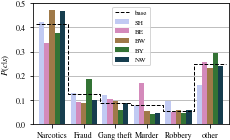

In [395]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
# plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=True))
# plt.rcParams.update(plt.rcParamsDefault)

rc_params= {
    # # 'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times'],
    'figure.figsize': (3.25, 2.0086104634371584),
    'figure.constrained_layout.use': True,
    'figure.autolayout': False,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.015,
    'font.size': 8,
    'axes.labelsize': 9,
    'legend.fontsize': 7,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.titlesize': 8
    }
plt.rcParams.update(rc_params)

x = np.arange(len(data_2021)+1)
color_list = ['cornflowerblue', 'burlywood', 'coral', 'cadetblue', 'darkgoldenrod'] 
color_list = cm.cubehelix_r(np.linspace(0.2, 0.8, len(color_list)))
step = 1/6
for i, s in enumerate(ok_population.sort_values('population').tail(5).state):
    y = list(data_2021[s]/data_2021[s].sum())
    ax.bar(x[:-1] + step*(i +1), y, color=color_list[i], label = s, width = 1/6)

    # ax.step(x, [y[0]] + y, label=s)
base = list(data_2021.overall_p)
ax.step(x, [base[0]] + base, c='black', ls='--', label='base', lw=1)
plt.xlim(-0.1, 6 + 0.1)
ax.set_ylim(0.,0.5)
ax.set_ylabel('$P(c|s)$')
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_xticks(x[1:]-.5, ['Narcotics', 'Fraud', 'Gang theft', 'Murder', 'Robbery', 'other'], rotation=0)
plt.savefig('../doc/fig/crime_dist.pdf')
plt.show()

In [393]:
from scipy.stats import chisquare

for s in ok_population.sort_values('population').tail(5).state:
    y = data_2021[s]
    print(s, chisquare(y, data_2021.overall_p * y.sum()))

SH Power_divergenceResult(statistic=73.83268204060597, pvalue=1.6298684305405572e-14)
BE Power_divergenceResult(statistic=183.0849644098325, pvalue=1.1735445584603102e-37)
BW Power_divergenceResult(statistic=53.86478017473398, pvalue=2.2343123411891797e-10)
BY Power_divergenceResult(statistic=268.14326051437166, pvalue=7.0088976330569125e-56)
NW Power_divergenceResult(statistic=26.911263307148065, pvalue=5.9357467996051825e-05)


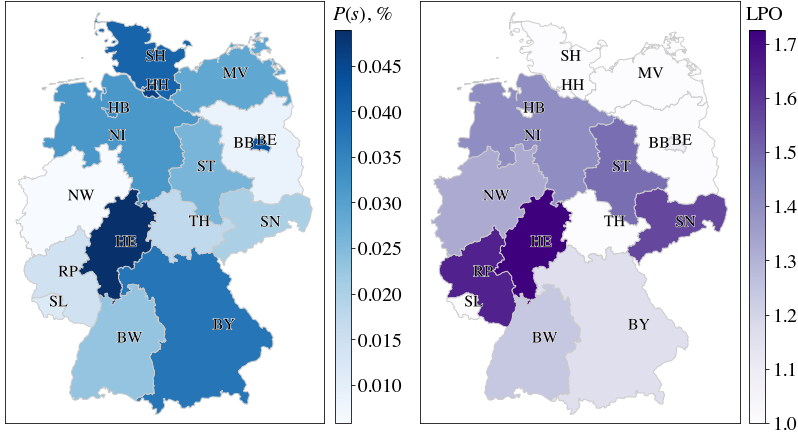

In [394]:
def plot_map_new(
        geo_df: pd.DataFrame, 
        columns: str, 
        title: str = None, 
        dst_path: str = None,
        cmap: str = 'Blues'):
    """
    Plot german map with colorbar.
    
    arguments:
    geo_df -- data prepared with `data_to_geo`
    column -- value which is used to indicate levels across states, e.g. 'cases_3_per_1k'
    title -- plot titile
    dst_path -- if provided save figure, e.g. './map_rel_2021.png'
    cmap -- colormap for the plot

    returns:
    fig, ax - tuple of matplotlib Figure and Axes
    """
    fig, axes = plt.subplots(1,2, figsize=(11.5, 6 ))
    cmap = ['Blues', 'Purples']

    

    for i, column, ax in zip(range(2), columns, axes):
        ax = geo_df.plot(column=column, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap[i])
        ax.set_title(title, fontdict={'fontsize': '16', 'fontweight': '3'})

        for idx, row in geo_df.iterrows():
            x = row['coords'][0] - 0.1
            y = row['coords'][1]
            text = ax.annotate(
                text=f"{row['state']}",
                xy=(x,y),
                xytext= (x,y), 
                fontsize=16,
                color='black',
            )
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                                path_effects.Normal()])

        # ax.axis('off')
        ax.set_xlim(5.5, 15.4)
        ax.set_ylim(47.1, 55.3)
        ax.set_xticks([])
        ax.set_yticks([])

        vmin, vmax = geo_df[column].min(), geo_df[column].max()
        sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap[i])
        step = [0.435, 0.935]
        cbaxes = fig.add_axes([step[i]+0.02, 0.015, 0.02, 1.-0.09])
        cbar = fig.colorbar(sm, cax=cbaxes)
        cbaxes.tick_params(labelsize=20)
        label = ['$P(s)$, %', 'LPO']
        cbaxes.annotate(label[i], (-3,404), color='black', xycoords='axes points', fontsize=20)

    if dst_path:
        plt.savefig(dst_path, dpi=400)

    return fig, ax

# f, a = gf.plot_map(geo_data.query('year==2021'), 'laws_per_order', 'Mean # of laws applied per order, 2021')
geo_data['case_4_proba_100'] = geo_data.case_4_proba*100
plot_map_new(geo_data.query('year==2021'), ['case_4_proba_100', 'laws_per_order'], dst_path='../doc/fig/maps.pdf')
plt.show()